# CIS519 Project - Cassava Leaf Image Classification

Kaggle link: https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data

# Configurations

## ABOUT RUN ALL

Warning: running all may retrain the model and lose data. Be cautious and flip the boolean flag below when necessary if doing so.

In [6]:
redo_data_clean = False
need_retrain_cnn = False
need_retrain_res = False
need_retrain_vit = False
need_clean = False

## Imports

In [7]:
import os
import io
import random
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import boto3
import sagemaker
from io import BytesIO
from sagemaker import get_execution_role

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image

from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

import pytz
import time

In [8]:
%%time
# Set the timezone to Pacific Time
pt = pytz.timezone('America/Los_Angeles')

role = get_execution_role()
print(role)

region = boto3.Session().region_name
sess = sagemaker.Session()

arn:aws:iam::968333200412:role/SageMakerExecutionRole
CPU times: user 150 ms, sys: 27 ms, total: 176 ms
Wall time: 228 ms


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Configuring S3 Datastore

In [10]:
s3_client = boto3.client('s3')

# List all the buckets
response = s3_client.list_buckets()

# Print the name of each bucket
for bucket in response['Buckets']:
    print(bucket['Name'])
    bucket_name = bucket['Name']

# List all the folders (prefixes) inside the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Delimiter='/')

# Print the name of each folder
for content in response.get('CommonPrefixes', []):
    print(content.get('Prefix'))

519bucket
dataset-backup/
dataset-latest/
dataset/


## Loading CSV Data

In [11]:
file_path = 'dataset/train.csv'
train_csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_path)
train_df =pd.read_csv(io.BytesIO(train_csv_obj['Body'].read()))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


## Loading Image Data

In [12]:
#count the total number of images 
csv_image_count = train_df['image_id'].count()
display(csv_image_count)

#check the file amount inside train_images folder
folder_path = 'dataset/train_images'

def count_files_in_s3_folder(bucket, prefix):
    paginator = s3_client.get_paginator('list_objects_v2')
    count = 0

    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'] != prefix:
                count += 1
                
    return count

number_of_files = count_files_in_s3_folder(bucket_name, folder_path)
print(f'There are {number_of_files} files in the folder {folder_path}.')


#check if they are the same
if csv_image_count == number_of_files:
    #show a green light symbol
    display("✅, all images are uploaded.")
else:
    #show a red light symbol
    display("❌, partial uploaded, missing images.")

21397

There are 9729 files in the folder dataset/train_images.


'❌, partial uploaded, missing images.'

## Cropping Data Size

**Since the upload speed for S3 would decrease like gradient, we are not able to obtain all train images. Hence here we do a data pre cleaning**

In [13]:
if need_clean:
    new_train_df = train_df.copy()
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        file_path = 'dataset/train_images/' + row['image_id']
        try:
            s3_client.head_object(Bucket=bucket_name, Key=file_path)
        except:
            new_train_df = new_train_df.drop(index)

    new_count = new_train_df['image_id'].count()
    display(new_count)
    new_train_df.head()
    
    clean_train_df = new_train_df.copy()
    #add time step to the file name
    clean_train_df.to_csv('clean_train_df_{}.csv'.format(time.time()), index=False)
    # show the label distribution in train
    clean_train_df['label'].value_counts().plot(kind='bar')

# EDA

In [14]:
read_file_from_s3 = lambda file_path: s3_client.get_object(Bucket=bucket_name, Key=file_path)['Body']

pd.read_csv(read_file_from_s3('dataset/train.csv'))

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<AxesSubplot:>

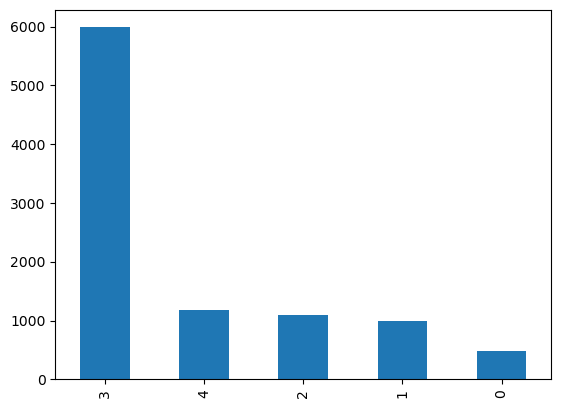

In [15]:
# Print labels and category encodings
path_prefix = 'dataset/'

# Load data
train = pd.read_csv('clean_train_df.csv')
test = pd.read_csv(read_file_from_s3('dataset/sample_submission.csv'))
label_map = pd.read_json(read_file_from_s3('dataset/label_num_to_disease_map.json'), orient='index')

# Print labels and category encodings
display(train.head())
display(test.head())
display(label_map)

# show the label distribution in train
train['label'].value_counts().plot(kind='bar')

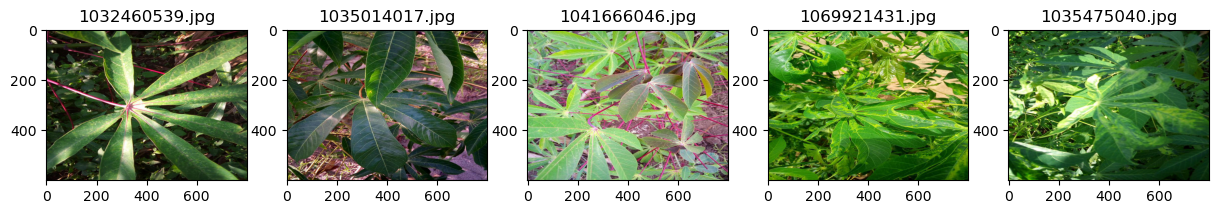

In [16]:
# Visualize raw images
image_dir = path_prefix + 'train_images/'

s3 = boto3.client('s3')
s3_objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=image_dir)['Contents']
image_files = [obj['Key'] for obj in s3_objects]
num_images = 5
sample_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
for i, image_file in enumerate(sample_images):
    image_bytes = read_file_from_s3(image_file)
    image = Image.open(image_bytes)
    axs[i].imshow(image)
    image_file_short = image_file.replace(image_dir, '')
    axs[i].set_title(image_file_short)
plt.show()

## Data Transformation & Augmentation

In [17]:
# Define basic transformation and augmentation
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, csv_path, s3_prefix, transform=None):
        self.data = pd.read_csv(csv_path)
        self.s3_prefix = s3_prefix
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = f"{self.s3_prefix}/{row['image_id']}"
        #now doing good thing
        image_bytes = read_file_from_s3(image_path)
        image = Image.open(image_bytes).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = row['label']
        return image, label
        
train_data_path = 'clean_train_df.csv'
s3_prefix = 'dataset/train_images'
dataset = CassavaDataset(train_data_path, s3_prefix, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


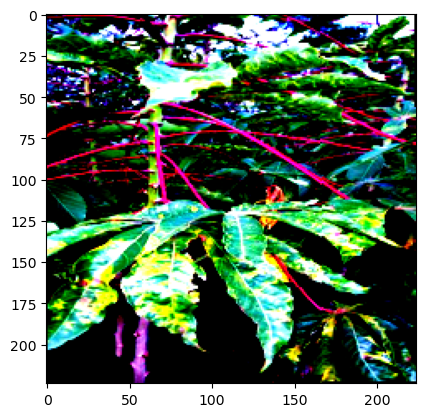

In [22]:
# Visualize transformed image
img_id = train.sample(1)['image_id'].values[0]
sample_image_path = path_prefix + 'train_images/'+ img_id
sample_image = Image.open(read_file_from_s3(sample_image_path))
transformed_image = transform(sample_image)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.show()

# 1. CNN Baseline

## 1.1 Implementation

In [18]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [19]:
# Train test split
num_train = int(len(dataset) * 0.7)
num_val = int(len(dataset) * 0.15)
num_test = len(dataset) - num_train - num_val
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test])

# Load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cnn = BasicCNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

if need_retrain_cnn:
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % 10 == 0:
                print('[Epoch: %d, Batch: %5d] Loss: %.3f' %
                      (epoch + 1, i, running_loss / 10))
                running_loss = 0.0

        correct = 0
        total = 0
            
        with torch.no_grad():
            for (inputs, labels) in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnn(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print('Epoch: %d, Validation accuracy: %d %%' % (epoch+1, val_acc))

## 1.2 Evaluation

In [20]:
cnn.eval()

correct = 0
total = 0
preds = np.array([])
labels = np.array([])
with torch.no_grad():
    for (inputs, targets) in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        preds = np.concatenate([preds, predicted.cpu().numpy()])
        labels = np.concatenate([labels, targets.cpu().numpy()])

test_acc = 100 * correct / total
print('Test accuracy: %d %%' % test_acc)

cm = confusion_matrix(labels, preds)
print('Confusion matrix:')
print(cm)

precision, recall, f1_score, support = precision_recall_fscore_support(labels, preds)
for i in range(len(precision)):
    print('Class %d:' % i)
    print('  Precision: %.3f' % precision[i])
    print('  Recall: %.3f' % recall[i])
    print('  F1 score: %.3f' % f1_score[i])
    print('  Support: %d' % support[i])

Test accuracy: 11 %
Confusion matrix:
[[  0   0   0   0  75]
 [  0   0   0   0 172]
 [  0   0   0   0 163]
 [  0   0   0   0 879]
 [  0   0   0   0 171]]
Class 0:
  Precision: 0.000
  Recall: 0.000
  F1 score: 0.000
  Support: 75
Class 1:
  Precision: 0.000
  Recall: 0.000
  F1 score: 0.000
  Support: 172
Class 2:
  Precision: 0.000
  Recall: 0.000
  F1 score: 0.000
  Support: 163
Class 3:
  Precision: 0.000
  Recall: 0.000
  F1 score: 0.000
  Support: 879
Class 4:
  Precision: 0.117
  Recall: 1.000
  F1 score: 0.210
  Support: 171


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Save the model
if need_retrain_cnn:
    timestamp = time.strftime('%H:%M')
    print("Current Pacific Time:", timestamp)
    cnn_model_path = f"models/cnn-{timestamp}.pth"
    torch.save(cnn.state_dict(), cnn_model_path)

# 2. Transfer Learning with ResNet

## 2.1 Implementation

In [23]:
# Train test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [24]:
print(torchvision.models.resnet.__all__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

['ResNet', 'ResNet18_Weights', 'ResNet34_Weights', 'ResNet50_Weights', 'ResNet101_Weights', 'ResNet152_Weights', 'ResNeXt50_32X4D_Weights', 'ResNeXt101_32X8D_Weights', 'ResNeXt101_64X4D_Weights', 'Wide_ResNet50_2_Weights', 'Wide_ResNet101_2_Weights', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d', 'wide_resnet50_2', 'wide_resnet101_2']
cuda


In [25]:
if need_retrain_res:
    # Get the current time in Pacific Time
    current_time = datetime.now(pt)
    # Define baseline model
    resnet = M.resnet18(pretrained=True)
    num_classes = 5
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, num_classes)
    resnet.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

    # Initialize GradScaler
    scaler = GradScaler()

    # Train baseline model (or more accurately, fine-tune the pre-trained model to apply on our specific dataset)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
            inputs = inputs.to(device) # Moved input data to the GPU
            labels = labels.to(device) # Moved target labels to the GPU

            optimizer.zero_grad()

            # Use autocast to perform automatic mixed precision training
            with autocast():
                outputs = resnet(inputs)
                loss = criterion(outputs, labels)

            # Scales the loss to avoid underflow or overflow
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

In [26]:
timestamp = current_time.strftime('%H:%M')
# Print the current time
print("Current Pacific Time:", timestamp)

model_path = f"models/resnet18-{timestamp}.pth"
torch.save(resnet.state_dict(), model_path)

NameError: name 'current_time' is not defined

Now Model is saved under models/ folder. We can load the model and test any time

## 2.2 Evalutation

Test on test_loader, and evaluate the model performance:
- Use a table to record accuracy, precision, recall, F1 score
- Draw confusion matrix, precision-recall curve
- Draw AUC-ROC figure

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn

'''
state_dict = torch.load("models/resnet18-20:03.pth")
print(state_dict.keys())

model = models.resnet18()
print(model.state_dict().keys())
'''

resnet = models.resnet18(pretrained=False)
num_classes = 5
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet.load_state_dict(torch.load("models/resnet18-20:03.pth"))
resnet.eval()

if torch.cuda.is_available(): resnet.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0       0.74      0.90      0.81        84
           1       0.94      0.87      0.90       202
           2       0.93      0.88      0.90       232
           3       0.98      0.96      0.97      1186
           4       0.80      0.93      0.86       242

    accuracy                           0.93      1946
   macro avg       0.88      0.91      0.89      1946
weighted avg       0.94      0.93      0.93      1946

Accuracy: 0.9332
Precision: 0.9387
Recall: 0.9332
F1 score: 0.9346
Confusion matrix:
[[  76    1    0    0    7]
 [  11  175    2    6    8]
 [   1    1  203    9   18]
 [   6    7   12 1137   24]
 [   9    2    2    4  225]]
probs labels shape: 1946
Class 0: AUC = 0.992
Class 1: AUC = 0.987
Class 2: AUC = 0.988
Class 3: AUC = 0.994
Class 4: AUC = 0.987
Micro-averaged AUC = 0.990


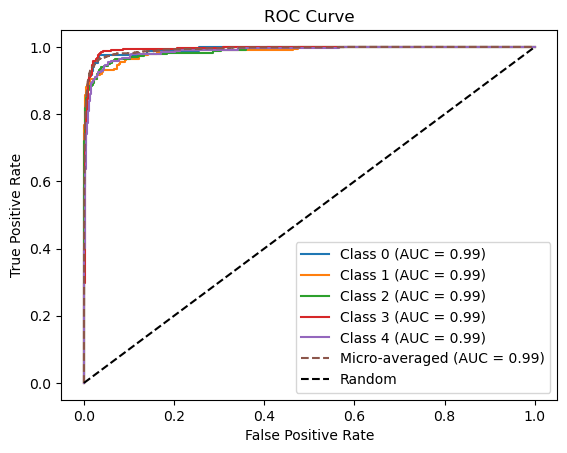

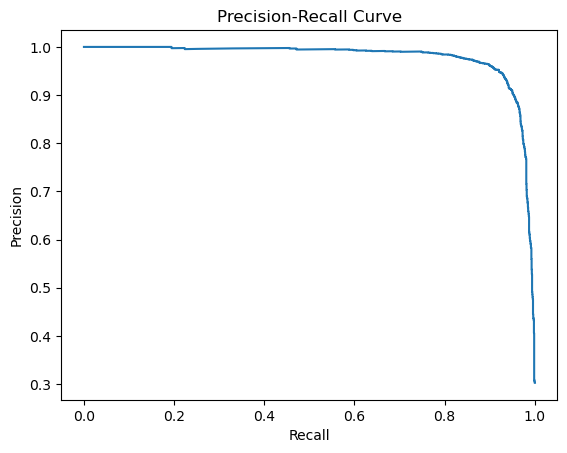

PR_AUC is  0.9780877822215752


'\nprecision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)\n# Print the results for each class\nfor i in range(num_classes):\n    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")\n# Plot the precision-recall curve\nplt.plot(recall, precision)\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve for baseline resnet-18\')\nplt.show()\n\nauc_roc = roc_auc_score(true_labels, pred_labels, multi_class=\'ova\')\nprint(f"auc_roc: {auc_roc:.4f}")\n'

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class
'''
moved above, this hasn't been deleted yet, del if above works
with torch.no_grad():
    probs = F.softmax(resnet(inputs), dim=1).cpu().numpy()
'''
probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)

'''
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label="class {} (AUC = {:.2f})".format(i, pr_auc[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
'''
'''
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)
# Print the results for each class
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for baseline resnet-18')
plt.show()

auc_roc = roc_auc_score(true_labels, pred_labels, multi_class='ova')
print(f"auc_roc: {auc_roc:.4f}")
'''

# 3. Fine-tuning Kaggle Solution

## 3.1 Implementation

### Base VIT Model

basic data load, seed and transform adpot from [here](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline/notebook#notebook-container)

In [46]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


seed_everything(1001)

import torchvision.transforms as transforms

IMG_SIZE = 224

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

### VIT Model

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
print(torch.__version__)

1.13.1


In [35]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 4.0 MB/s eta 0:00:0000:01


In [36]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import timm

class VitClassifier(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", n_classes=5, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_classes)
        
        self.best_val_loss = float('inf')  # initialize best validation loss to infinity
        self.early_stopping_rounds = 3  # number of epochs to wait before early stopping
        self.epochs_without_improvement = 0  # number of epochs without improvement
        
        self.scaler = GradScaler()  # initialize GradScaler
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def evaluate(self, loader, criterion, device):
        self.model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                val_loss += criterion(output, target).item()
                val_acc += (output.argmax(1) == target).sum().item()

        val_loss /= len(loader)
        val_acc /= len(loader.dataset)
        return val_loss, val_acc
    
    def train_one(self, loader, optimizer, criterion, device, val_loader=None):
        self.model.train()
        train_loss = 0
        train_acc = 0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for step, batch in pbar:
            optimizer.zero_grad()
            data, target = batch
            data, target = data.to(device), target.to(device)

            with autocast():
                output = self.model(data)
                loss = criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()

            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()

        train_loss /= len(loader)
        train_acc /= len(loader.dataset)

        if val_loader is not None:
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.early_stopping_rounds:
            print(f'Validation loss has not improved in {self.early_stopping_rounds} epochs. Early stopping...')
            return train_loss, train_acc, True
        else:
            return train_loss, train_acc, False


In [ ]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)

torch.cuda.empty_cache()

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-05)

criterion = nn.CrossEntropyLoss()

batch_size_vit = 16
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)


def train(model, optimizer, criterion, train_loader, val_loader, device, epochs=4):
    current_time = datetime.now(pt)
    timestamp = current_time.strftime('%m/%d %H:%M')
    print(f"total train epochs: {epochs}")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}  / {epochs}")
        train_loss, train_acc, early_stopping = model.train_one(train_loader, optimizer, criterion, device)
        val_loss, val_acc = model.evaluate(val_loader, criterion, device)
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        torch.save(model.state_dict(), f"models/vit_{timestamp}_epoch_{epoch}.pth")
    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return train_losses, train_accs, val_losses, val_accs
if need_retrain_vit:
    train_losses, train_accs, val_losses, val_accs = train(model, optimizer, criterion, train_loader, test_loader, device, epochs=10)
    current_time = datetime.now(pt)
    timestamp = current_time.strftime('%H:%M')

In [ ]:
# Save model with timestamp
torch.save(model.state_dict(), f"models/vit_{timestamp}.pth")

# Create pandas DataFrame with training/validation results
df = pd.DataFrame({
    'train_loss': train_losses, 
    'train_acc': train_accs, 
    'val_loss': val_losses, 
    'val_acc': val_accs
})

# Save CSV with timestamp
df.to_csv(f"vit_loss_{timestamp}.csv", index=False)

## 3.2 Evaluation

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

In [41]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)
state_dict = torch.load(f"models/vit_23:29_epoch_2.pth")
model.load_state_dict(state_dict)

model.eval()

if torch.cuda.is_available(): model.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (inputs, labels) in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

100%|██████████| 61/61 [03:10<00:00,  3.12s/it]


              precision    recall  f1-score   support

           0       0.62      0.89      0.73        84
           1       0.82      0.88      0.85       202
           2       0.95      0.72      0.82       232
           3       0.91      0.99      0.95      1186
           4       0.92      0.56      0.69       242

    accuracy                           0.89      1946
   macro avg       0.84      0.81      0.81      1946
weighted avg       0.90      0.89      0.88      1946

Accuracy: 0.8880
Precision: 0.8955
Recall: 0.8880
F1 score: 0.8824
Confusion matrix:
[[  75    6    0    2    1]
 [   9  177    0   12    4]
 [   4    6  168   50    4]
 [   0    8    2 1173    3]
 [  33   19    7   48  135]]
probs labels shape: 1946
Class 0: AUC = 0.985
Class 1: AUC = 0.990
Class 2: AUC = 0.980
Class 3: AUC = 0.990
Class 4: AUC = 0.978
Micro-averaged AUC = 0.984


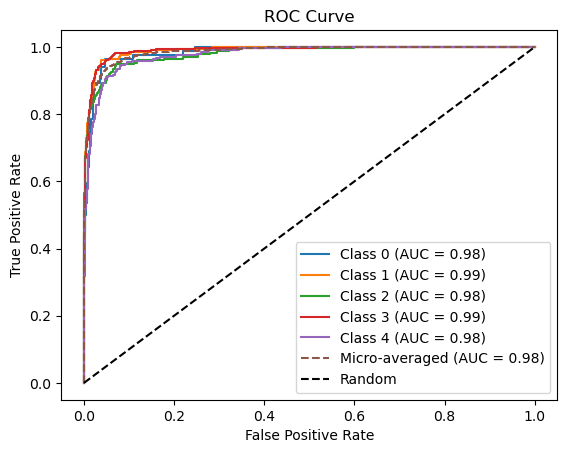

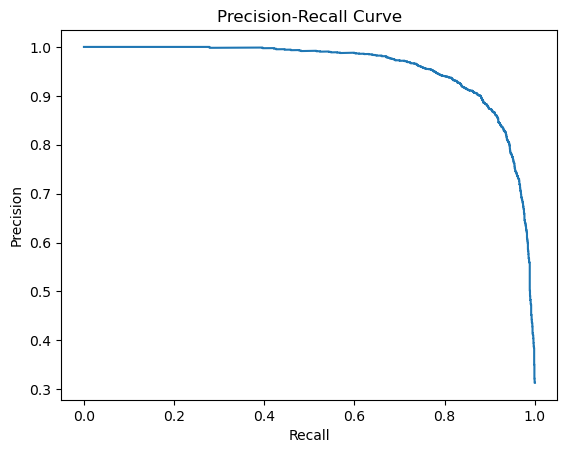

PR_AUC is  0.9567897562859021


In [43]:
print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
num_classes = 5
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class

probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)

# 4. Datashift Evaluation

## Evaluation on test set with different transfromations 

In [47]:
transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

valid_dataset = CassavaDataset(train_data_path, s3_prefix, transform=transforms_valid)
_, valid_test_dataset = random_split(valid_dataset, [train_size, test_size])

# Load data
batch_size = 32
valid_test_loader = DataLoader(valid_test_dataset, batch_size=batch_size, shuffle=True)

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn

'''
state_dict = torch.load("models/resnet18-20:03.pth")
print(state_dict.keys())

model = models.resnet18()
print(model.state_dict().keys())
'''

resnet = models.resnet18(pretrained=False)
num_classes = 5
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet.load_state_dict(torch.load("models/resnet18-20:03.pth"))
resnet.eval()

if torch.cuda.is_available(): resnet.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    for inputs, labels in valid_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0       0.56      0.80      0.66        85
           1       0.87      0.75      0.81       209
           2       0.81      0.70      0.75       226
           3       0.97      0.93      0.95      1192
           4       0.65      0.83      0.73       234

    accuracy                           0.87      1946
   macro avg       0.77      0.80      0.78      1946
weighted avg       0.88      0.87      0.87      1946

Accuracy: 0.8684
Precision: 0.8830
Recall: 0.8684
F1 score: 0.8723
Confusion matrix:
[[  68    2    1    1   13]
 [  17  157    1    7   27]
 [   7    5  159   23   32]
 [  12   10   27 1111   32]
 [  18    6    9    6  195]]
probs labels shape: 1946
Class 0: AUC = 0.979
Class 1: AUC = 0.979
Class 2: AUC = 0.958
Class 3: AUC = 0.984
Class 4: AUC = 0.967
Micro-averaged AUC = 0.973


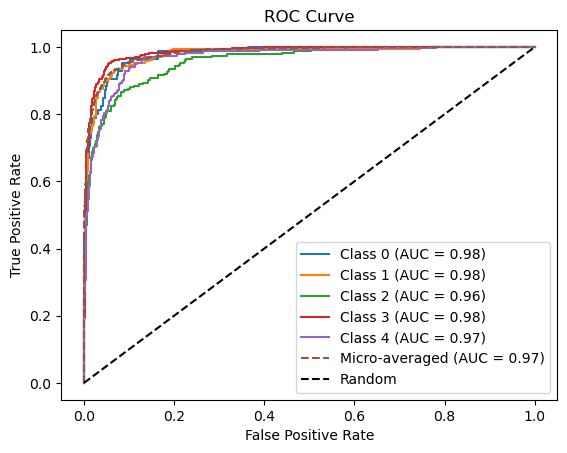

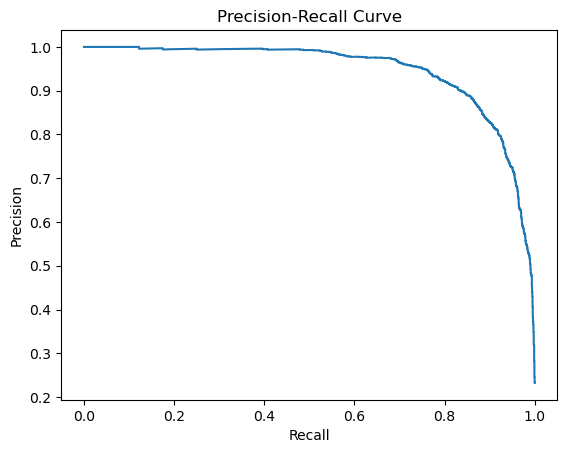

PR_AUC is  0.9450046210547643


'\nprecision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)\n# Print the results for each class\nfor i in range(num_classes):\n    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")\n# Plot the precision-recall curve\nplt.plot(recall, precision)\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve for baseline resnet-18\')\nplt.show()\n\nauc_roc = roc_auc_score(true_labels, pred_labels, multi_class=\'ova\')\nprint(f"auc_roc: {auc_roc:.4f}")\n'

In [49]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class
'''
moved above, this hasn't been deleted yet, del if above works
with torch.no_grad():
    probs = F.softmax(resnet(inputs), dim=1).cpu().numpy()
'''
probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)




'''
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label="class {} (AUC = {:.2f})".format(i, pr_auc[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
'''
'''
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)
# Print the results for each class
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for baseline resnet-18')
plt.show()

auc_roc = roc_auc_score(true_labels, pred_labels, multi_class='ova')
print(f"auc_roc: {auc_roc:.4f}")
'''